In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\magicgui\widgets\_bases\ranged_widget.py:28: FutureWarning: The 'maximum' keyword arguments has been changed to 'max'. In the future this will raise an exception

  warn(
C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\magicgui\widgets\_bases\ranged_widget.py:28: FutureWarning: The 'minimum' keyword arguments has been changed to 'min'. In the future this will raise an exception

  warn(


<Intel(R) UHD Graphics on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
%gui qt

In [3]:

import napari

napari.gui_qt()        
viewer = napari.Viewer()

In [4]:
# convenience methods
def show(image, labels=False, title=None, use_napari=False):
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if labels:
            viewer.add_labels(cle.pull_zyx(image).astype(int), name=title)
        else:
            viewer.add_image(cle.pull_zyx(image), name=title)


In [5]:
# Configure data source
path = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR'

timepoint_in_h = 19

cc_dataset = bs.ClearControlDataset(path)

print("Duration in seconds:", cc_dataset.get_duration_in_seconds())

print("Duration in hours:", bs.seconds_to_hours(cc_dataset.get_duration_in_seconds()))

Duration in seconds: 607654.0077
Duration in hours: 168.79277991666666


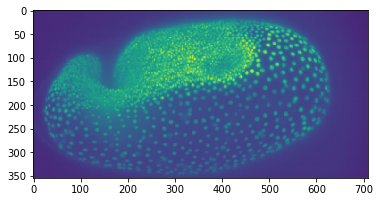

(213, 710, 355)


In [6]:
input_image = cc_dataset.get_resampled_image(time_in_seconds=bs.hours_to_seconds(timepoint_in_h), linear_interpolation=True)
show(input_image, title="original", use_napari=True)
print(input_image.shape)

# Segmentation

Segmentation took 26.17757487297058 s


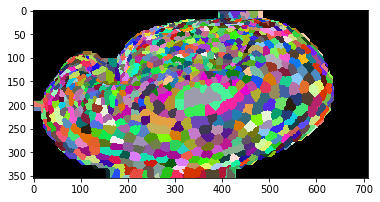

In [7]:
cells, spots = bs.segmentation(input_image, spot_detection_threshold=50)
show(cells, labels=True,  use_napari=True)

# Quantiative analysis
## Average distance of n=6 nearest neighbors

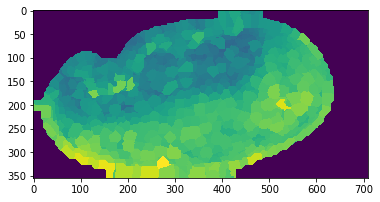

In [8]:
avg_distance_map = cle.average_distance_of_n_closest_neighbors_map(cells, n = 6)
show(avg_distance_map, labels=False, use_napari=True, title="avg_distance_map")

## Locally averaged over the touching neighbors

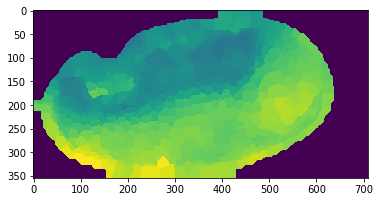

In [9]:
mean_distance_map = cle.mean_of_touching_neighbors_map(avg_distance_map, cells)

show(mean_distance_map, labels=False, use_napari=True, title="mean_distance_map")

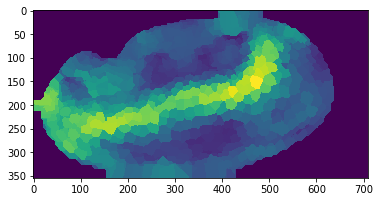

In [10]:
local_stddev_distance_map = cle.standard_deviation_of_touching_neighbors_map(mean_distance_map, cells, radius=2)
show(local_stddev_distance_map, labels=False, use_napari=True, title="local_stddev_distance_map")

In [11]:
data =  np.asarray([
    cle.pull(cle.read_intensities_from_map(cells, avg_distance_map))[0],
    cle.pull(cle.read_intensities_from_map(cells, mean_distance_map))[0],
    cle.pull(cle.read_intensities_from_map(cells, local_stddev_distance_map))[0]
])

print(data.shape)

(3, 1546)


## Ploting the raw measurements

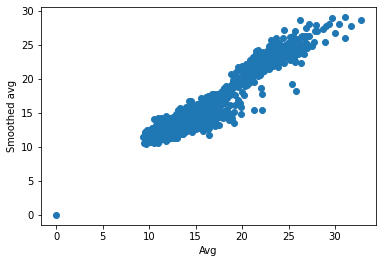

In [12]:
import matplotlib.pyplot as plt

plt.scatter(data[0], data[1])
plt.xlabel("Avg")
plt.ylabel("Smoothed avg")
plt.show()

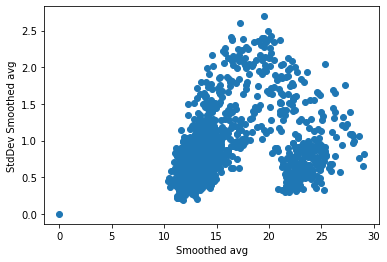

In [13]:
plt.scatter(data[1], data[2])
plt.xlabel("Smoothed avg")
plt.ylabel("StdDev Smoothed avg")
plt.show()

# Clustering

In [14]:
num_classes = 3

data = data.T
print(data.shape)

(1546, 3)


In [15]:
def show_prediction(cells, prediction, name = "", use_napari=True):
    predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

    # set background to 0
    cle.set_column(predicition_vector, 0, 0)
    print(predicition_vector)

    print(prediction)
    print(np.max(prediction))

    prediction_map = cle.replace_intensities(cells, predicition_vector)
    show(prediction_map, title="prediction " + name, use_napari=use_napari)

## Gaussian mixture model

In [16]:
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)
# print(clf.means_, clf.covariances_)

GaussianMixture(n_components=3)

In [17]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

gmm_prediction = clf.predict(data)

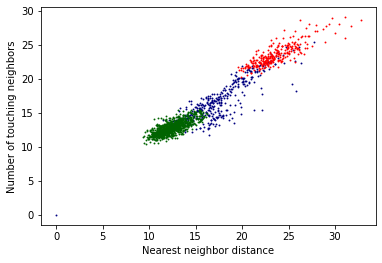

In [18]:
for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[gmm_prediction == i, 0], data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

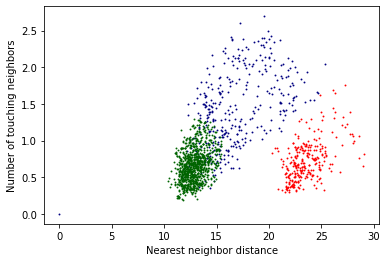

In [19]:

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[gmm_prediction == i, 1], data[gmm_prediction == i, 2], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

[[0. 1. 1. ... 1. 1. 1.]]
[0 0 0 ... 0 0 0]
2


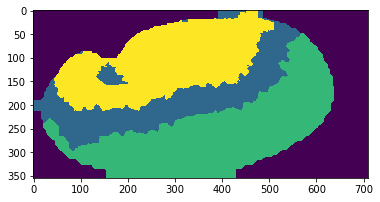

In [20]:
show_prediction(cells, gmm_prediction, "Gaussian Mixture")

## K-means clustering

[2 1 1 ... 0 1 1]
[[0. 2. 2. ... 1. 2. 2.]]
[2 1 1 ... 0 1 1]
2


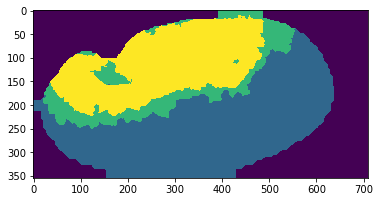

In [21]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(data)

kmeans_prediction = kmeans.predict(data)

print(kmeans_prediction)

show_prediction(cells, kmeans_prediction, "K-means clustering")